In [237]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics

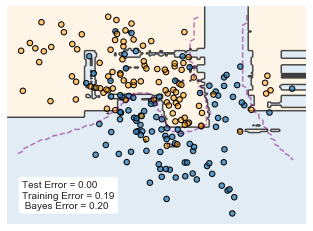

In [238]:
#reading mixture data
data = pd.read_csv('./ESL-data/ESLMixtureData.csv').iloc[:,1:]

#reading data for bayesian
px1 = pd.read_csv('./ESL-data/ESLpx1.csv').iloc[:,1]
px2 = pd.read_csv('./ESL-data/ESLpx2.csv').iloc[:,1]

prob = np.array(pd.read_csv('./ESL-data/ESLprob.csv').iloc[:,1].values).reshape(len(px2),len(px1))
prob_list = pd.read_csv('./ESL-data/ESLprob.csv').iloc[:,1]

marginal = pd.read_csv('./ESL-data/ESLmarginal.csv').iloc[:,1]

prob_list[prob_list >= .5] = 1 - prob_list[prob_list >= .5].values
bayes_error = np.sum(marginal*prob_list)/len(marginal)


def visualize_classifier(model, X, Y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    #work on colors
    colors = [(0.1500, 0.4667, 0.7059, 0.7), (1.000, 0.6, 0.002, 0.5)]
    cmap = ListedColormap(colors)
    
    #bayes
    PX1, PX2 = np.meshgrid(px1, px2)
    prob[prob >= 0.5] = 1
    prob[prob < 0.5] = 0
    
        
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=cmap, clim=(Y.min(), Y.max()), edgecolor=["black"])
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(X, Y)
    x, y = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    #column stack
    xy = np.c_[x.ravel(), y.ravel()]
    Z = model.predict(xy).reshape(x.shape)
    
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    #random forest contour line
    contours = ax.contour(x, y, Z, alpha=0.7,
                          levels=np.arange(n_classes + 1) - 0.5,
                         zorder=0.5, colors = ['k'], linestyles = ['-'])
    #bayes line
    ax.contour(PX1, PX2, prob, levels=[.5],
            colors='purple', linestyles='--', alpha = 0.5)
    
    #showing the prediction line
    grid_label =model.predict(xy)
    grid = np.hstack([xy, grid_label[:,np.newaxis]])
    grid  = pd.DataFrame(grid)
    #for the background
    plt.imshow(Z, extent=[-2.864396, 4.514322, -2.256491, 3.112442], origin='lower',cmap=cmap, alpha=0.2)
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    
    #test and training errors
    test = 1 - model.score(X,Y);
    train = 1- model.oob_score_;
    
    textstr = '\n'.join((r'Test Error = %.2f' % (test, ),
                         r'Training Error = %.2f' % (train, ),
                         r' Bayes Error = %.2f' % (bayes_error*3.1, )))
    
    ax.text(0.05, .2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    ax.set(xlim=xlim, ylim=ylim)

#setting up the random forest
model = RandomForestClassifier(n_estimators=100, random_state=0, oob_score= True)
#sending it to be printed
visualize_classifier(model, np.array(data.iloc[:,0:2]), np.array(data.iloc[:,-1]));
